In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import test_s_curve, hhRNADataset, hhATACDataset, test_paul, symsim_batches, cardiacRNADataset, cardiacATACDataset

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 64,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    
    DPT1 = torch.FloatTensor(DPT1).to(device)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    DPT2 = diff.DPT_similarity(data["count"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    
    DPT2 = torch.FloatTensor(DPT2).to(device)

In [3]:
def train_unpaired(model_rna, model_atac, disc, data_loader_rna, data_loader_atac, diff_sim_rna, diff_sim_atac, n_epochs = 50, lamb_r = 1, lamb_d = 1):

    for epoch in range(n_epochs):
        iteration = max(len(data_loader_rna), len(data_loader_atac))
        for data in zip(data_loader_rna, data_loader_atac):
            # Update RNA Encoder
            data_rna, data_atac = data
            batch_cols_rna = data_rna['index'].to(device)
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count'].to(device)

            batch_expr_r_rna = model_rna(batch_expr_rna)
            z_rna = model_rna[:1](batch_expr_rna)
#             traj_loss(recon_x, x, z, diff_sim, lamb_recon = 1, lamb_dist = 1, recon_mode = "original")
            train_loss_rna, loss_recon_rna, loss_dist_rna = traj_loss(recon_x = batch_expr_r_rna, x = batch_expr_rna, \
                                                                      z = z_rna, diff_sim = batch_sim_rna, \
                                                                      lamb_recon = lamb_r, lamb_dist = lamb_d, recon_mode = "relative")

            train_loss_rna.backward()
            optimizer_rna.step()
            optimizer_rna.zero_grad()

            # Update ATAC Encoder
            batch_cols_atac = data_atac['index'].to(device)
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count'].to(device)

            batch_expr_r_atac = model_atac(batch_expr_atac)
            z_atac = model_atac[:1](batch_expr_atac)

            train_loss_atac, loss_recon_atac, loss_dist_atac = traj_loss(recon_x = batch_expr_r_atac, x = batch_expr_atac, \
                                                                         z = z_atac, diff_sim = batch_sim_atac, \
                                                                         lamb_recon = lamb_r, lamb_dist = lamb_d, recon_mode = "relative")

            train_loss_atac.backward()
            optimizer_atac.step()
            optimizer_atac.zero_grad()

            # need to go through all the calculation again since the encoder has been updated, ERROR shows up in pytorch 1.5 and above.
            # see: https://github.com/pytorch/pytorch/issues/39141 
            z_rna = model_rna[:1](batch_expr_rna)
            z_atac = model_atac[:1](batch_expr_atac)

            # Update Discriminator
            D_loss_avg = 0
            n_iter = 20
            n_rna = batch_cols_rna.shape[0]
            n_atac = batch_cols_atac.shape[0]
            # note that detach here is necessary, use directly will cause error in encoder update later
            input_disc = torch.cat((z_rna.detach(), z_atac.detach()), dim = 0)
            target = torch.cat((torch.full((n_rna, ), 0, dtype = torch.float), torch.full((n_atac, ), 1, dtype = torch.float))).to(device)
            

            for i in range(n_iter):
                output = disc(input_disc).squeeze()
                D_loss = F.binary_cross_entropy(output, target)
                D_loss_avg += D_loss.item()
                D_loss.backward()
                optimizer_D.step()
                optimizer_D.zero_grad()
            D_loss_avg /= n_iter

            # Update Encoder
            E_loss = -1 * F.binary_cross_entropy(disc(torch.cat((z_rna, z_atac), dim = 0)).squeeze(), target)
            E_loss.backward()
            optimizer_rna.step()
            optimizer_atac.step()
            optimizer_rna.zero_grad()
            optimizer_atac.zero_grad()

        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item())
            log_D = "Discriminator loss: {:.5f}".format(D_loss_avg)
            print("epoch: ", epoch, log_rna, log_atac, log_D)


In [4]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 1e-3)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 1e-3)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [5]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, n_epochs=201, lamb_r = 1, lamb_d = 1)

epoch:  0 RNA loss: 2.47607, RNA recon loss: 3.36047, RNA dist loss: -0.88440 ATAC loss: 2.27220, ATAC recon loss: 3.07829, ATAC dist loss: -0.80609 Discriminator loss: 0.65039
epoch:  10 RNA loss: -0.07567, RNA recon loss: 0.87529, RNA dist loss: -0.95097 ATAC loss: -0.13774, ATAC recon loss: 0.81757, ATAC dist loss: -0.95530 Discriminator loss: 0.65179
epoch:  20 RNA loss: -0.41539, RNA recon loss: 0.54546, RNA dist loss: -0.96085 ATAC loss: -0.47466, ATAC recon loss: 0.48428, ATAC dist loss: -0.95894 Discriminator loss: 0.63416
epoch:  30 RNA loss: -0.55721, RNA recon loss: 0.41102, RNA dist loss: -0.96823 ATAC loss: -0.59946, ATAC recon loss: 0.37090, ATAC dist loss: -0.97036 Discriminator loss: 0.64409
epoch:  40 RNA loss: -0.64129, RNA recon loss: 0.33239, RNA dist loss: -0.97368 ATAC loss: -0.66205, ATAC recon loss: 0.31632, ATAC dist loss: -0.97837 Discriminator loss: 0.62618
epoch:  50 RNA loss: -0.74085, RNA recon loss: 0.22420, RNA dist loss: -0.96505 ATAC loss: -0.75319, AT

In [23]:
torch.save({
    'ae1': ae1.state_dict(),
    'optim_ae1': optimizer_rna.state_dict(),
    'ae2': ae2.state_dict(),
    'optim_ae2': optimizer_rna.state_dict(),
    'disc': disc.state_dict(),
    'optim_disc': optimizer_D.state_dict(),
    'config': symsim_CONFIG
}, './saved_model/symsim_phate.pt')

In [25]:
state = torch.load('./saved_model/symsim_phate.pt')

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)
ae1.load_state_dict(state['ae1'])

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_CONFIG)), 
        ("decoder", ae.Decoder(symsim_CONFIG))
      ])).to(device)
ae2.load_state_dict(state['ae2'])

disc = ae.discriminator().to(device)
disc.load_state_dict(state['disc'])

<All keys matched successfully>

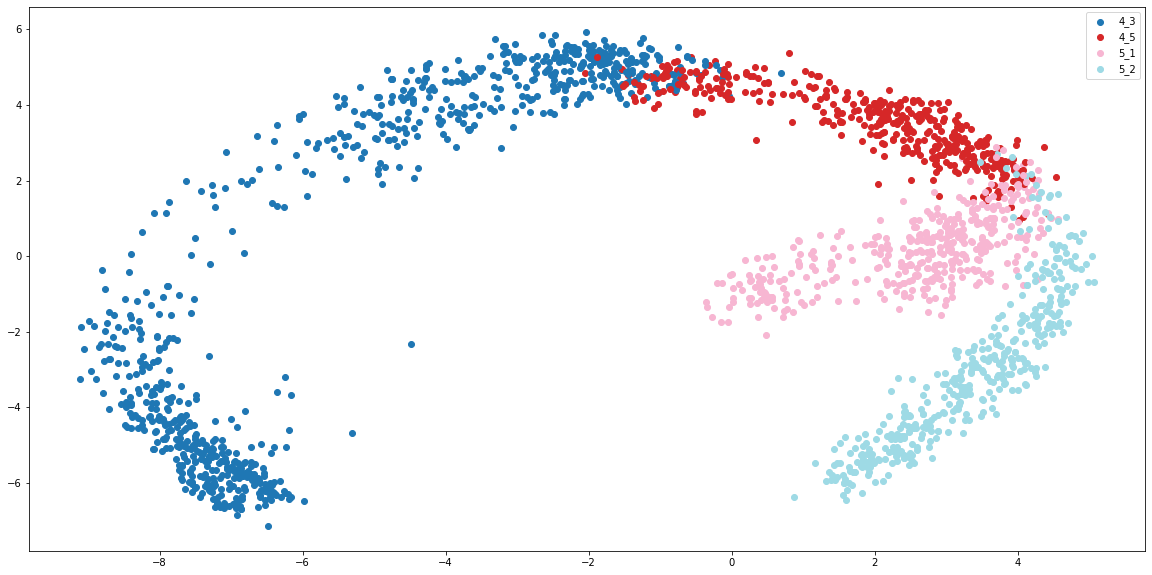

In [26]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)


for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)
fig.savefig("./result/Symsim/phate_backbones.pdf")

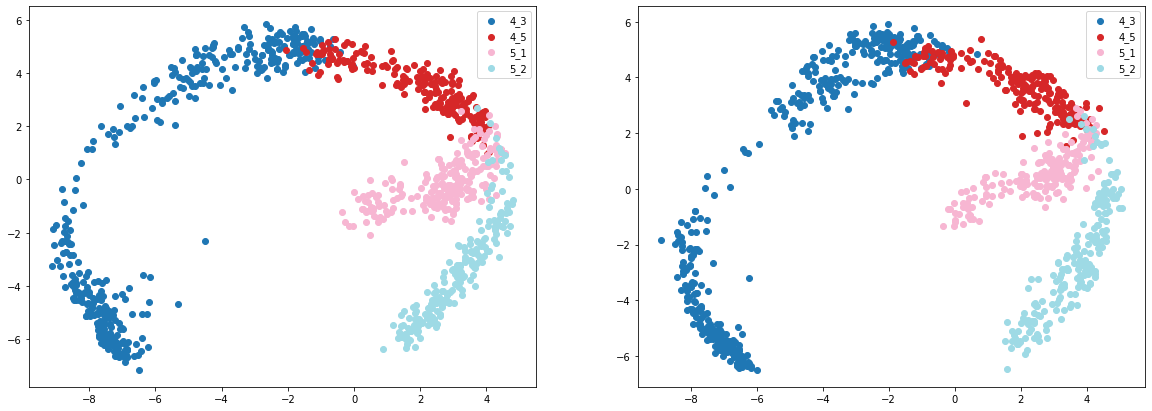

In [27]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1,2)

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[0].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)
axs[0].legend(cluster_types)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[1].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

axs[1].legend(cluster_types)

fig.savefig("./result/Symsim/phate_backbones_separate.pdf")

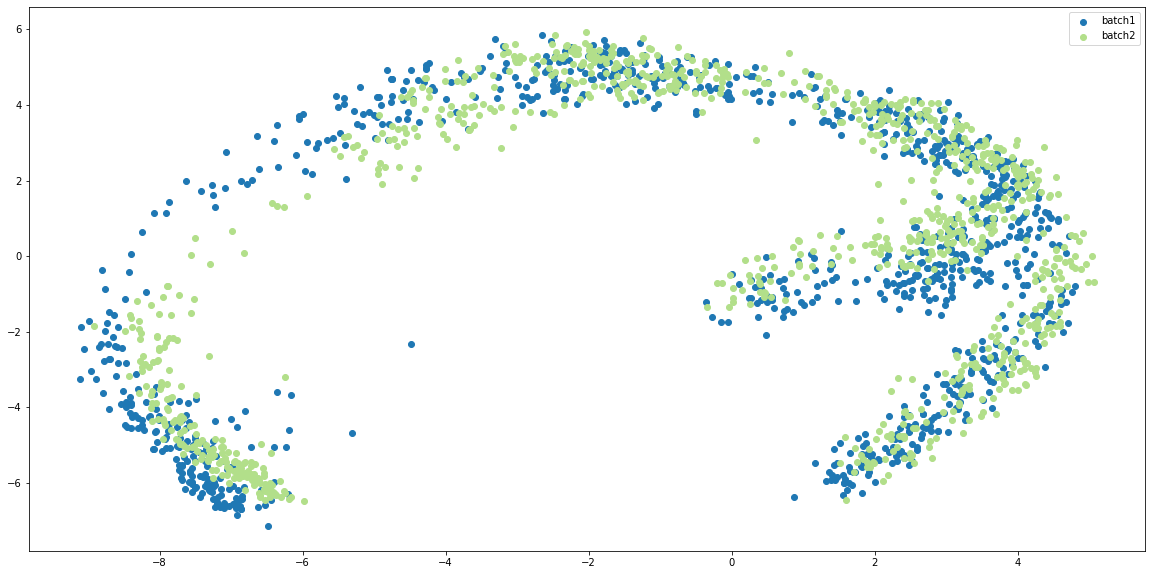

In [28]:
ae1.eval()
ae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
colormap = plt.cm.get_cmap("Paired")

for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(1), label = "batch1", alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = ae2[:1](data['count'].to(device)).cpu().detach().numpy()
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(2), label = "batch2", alpha = 1)

ax.legend()

fig.savefig("./result/Symsim/phate_batches_phate.pdf")